# Time Series Tutorial
[Youtube sktime tutorial](https://www.youtube.com/watch?v=wqQKFu41FIw&list=LL&index=1)

[GitHub sktime](https://github.com/alan-turing-institute/sktime)

In [1]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# from sktime.datasets import load_airline
# from sktime.forecasting.model_selection import temporal_train_test_split
# from sktime.performance_metrics.forecasting import smape_loss

# %matplotlib inline

### Intro

In [2]:
# y = load_airline().to_frame()
# plt.figure(figsize=(14, 4))
# plt.plot(y.values)
# plt.xlabel('Time')
# plt.ylabel('Number of Airline Passengers')

In [3]:
# y_train, y_test = temporal_train_test_split(y, test_size=0.25)
# print(len(y_train), len(y_test))

# x_train = np.arange(1, len(y_train) + 1).reshape(-1, 1)
# x_test = np.arange(len(y_train) + 1, len(y_train) + len(y_test) + 1).reshape(-1, 1)

In [4]:
# plt.figure(figsize=(14, 4))
# plt.plot(x_train, y_train.values, label='y_train')
# plt.plot(x_test, y_test.values, label='y_test')
# plt.legend()

In [5]:
# # We can specify the forecasting horizon as a numpy array of the steps ahead relative to the end of the training series
# fh = np.arange(1, len(y_test) + 1)
# fh
# # So we are interested in predicting from the first to the 36th step ahead

### Simple forecasting

In [6]:
# y_pred = np.repeat(y_train.iloc[-1].values, len(fh))
# y_pred = pd.Series(y_pred, index=y_test.index)

# plt.figure(figsize=(14, 4))
# plt.plot(x_train, y_train.values, label='y_train')
# plt.plot(x_test, y_test.values, label='y_test')
# plt.plot(x_test, y_pred.values, label='y_pred')
# plt.legend()

### Using sktime

In [7]:
# from sktime.forecasting.naive import NaiveForecaster

# forecaster = NaiveForecaster(strategy='last')
# forecaster.fit(y_train['Number of airline passengers'])
# y_pred = forecaster.predict(fh)

# plt.figure(figsize=(14, 4))
# plt.plot(x_train, y_train.values, label='y_train')
# plt.plot(x_test, y_test.values, label='y_test')
# plt.plot(x_test, y_pred.values, label='y_pred')
# plt.legend()

# smape_loss(y_pred, y_test['Number of airline passengers'])

In [8]:
# from sktime.forecasting.naive import NaiveForecaster

# forecaster = NaiveForecaster(strategy='last', sp=12)
# forecaster.fit(y_train['Number of airline passengers'])
# y_pred = forecaster.predict(fh)

# plt.figure(figsize=(14, 4))
# plt.plot(x_train, y_train.values, label='y_train')
# plt.plot(x_test, y_test.values, label='y_test')
# plt.plot(x_test, y_pred.values, label='y_pred')
# plt.legend()

# smape_loss(y_pred, y_test['Number of airline passengers'])

## Recurrent Neural Networks (RNN)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sktime.datasets import load_airline


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import ConvLSTM2D

ModuleNotFoundError: No module named 'sktime'

In [ ]:
# Load the dataframe
data = load_airline().to_frame().reset_index(drop=True)
plt.figure(figsize=(14, 5))
plt.plot(data)

### Data Preprocessing

In [6]:
# Convert dataframe to numpy array and set values to float
dataset = data.values
dataset = dataset.astype('float32')

In [7]:
# LSTM uses sigmoid and tanh which are sensitive to magnitude so large values need to be scaled
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

In [8]:
# We cannot split data into training and test sets randomly as the sequence of events is important for timme series.
train_size = int(0.66 * len(dataset))
test_size = len(dataset) - train_size
train, test = dataset[:train_size], dataset[-test_size:]

In [9]:
# We have train and test sets, but we need to transform our data into something similar to X and y to fit a model.
# So X will be a matrix instead of a vector, formed by the past values of itself.

def to_sequences(dataset, seq_size):
    """
    Transforms x values into a matrix in order to fit a model.
    
    Parameters
    ----------
    dataset : data for study. type() == np.array
    seq_size : number of past periods we want to use to predict    
    """
    x = []
    y = []
    
    for i in range(len(dataset) - seq_size - 1):
        window = dataset[i:(i + seq_size), 0]
        x.append(window)
        y.append(dataset[i + seq_size, 0])
    
    return np.array(x), np.array(y)

In [11]:
# Number of time steps to look back
# Larger sequences look far back in the past and may improve forecasting
seq_size = 12

X_train, y_train = to_sequences(train, seq_size)
X_test, y_test = to_sequences(test, seq_size)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(82, 12) (82,)
(36, 12) (36,)


In [12]:
# Reshape input values for the model to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Building Models

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                19712     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________
Train on 82 samples, validate on 36 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
82/82 - 1s - loss: 0.0616 - val_loss: 0.2510
Epoch 2/100
82/82 - 0s - loss: 0.0312 - val_loss: 0.1245
Epoch 3/100


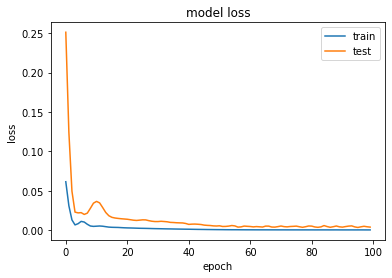

In [13]:
# Single LSTM with a hidden Dense
model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))   # 1 neuron output, which is our y value
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=2)

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# Do not put too many hidden layers because migth cause overfitting on the training data

In [19]:
# # Stack 2 LSTMs now with a hidden Dense layer
# # In order to stack 2 LSTMs we need return_sequences=True
# model = Sequential()
# model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(None, seq_size)))
# model.add(LSTM(50, activation='relu'))
# model.add(Dense(32))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mean_squared_error')

# model.summary()

# # Fit the model
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=2, epochs=100)

# # Summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 1, 64)          19712     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________
Train on 82 samples, validate on 36 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.

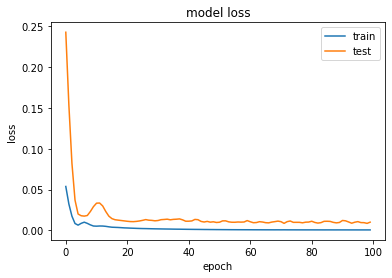

In [20]:
# # ConvLSTM
# # The layer expects input as a sequence of two-dimensional images,
# # therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

# X_train = X_train.reshape((X_train.shape[0], 1, 1, 1, seq_size))
# X_test = X_test.reshape((X_test.shape[0], 1, 1, 1, seq_size))

# model = Sequential()
# model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
# model.add(Flatten())
# model.add(Dense(32))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mean_squared_error')
# model.summary()

# # Fit the model
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=2, epochs=100)

# # Summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')

In [14]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions back to prescaled values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [15]:
# Calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = math.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))

print('Train Score: %.2f RMSE' %train_score)
print('Test Score: %.2f RMSE' %test_score)

Train Score: 12.20 RMSE
Test Score: 33.20 RMSE


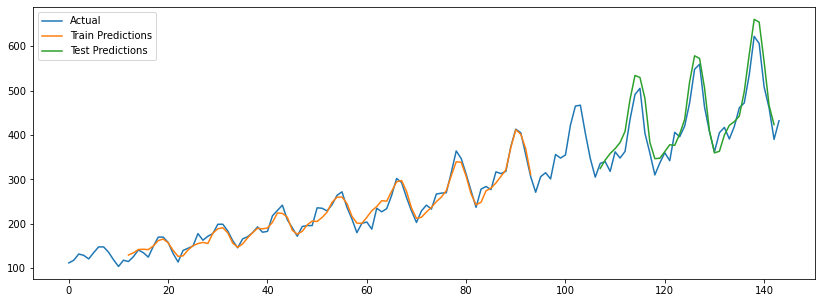

In [16]:
# Shift train predictions for plotting
# We must shift the predictions so that they align on the x-axis with the original dataset. 
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[seq_size : len(train_predict) + seq_size, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (seq_size * 2) + 1 : len(dataset) - 1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(14, 5))
plt.plot(scaler.inverse_transform(dataset), label='Actual', color='#3949AB')
plt.plot(train_predict_plot, label='Train Predictions', color='forestgreen')
plt.plot(test_predict_plot, label='Test Predictions', color='darkorange')
plt.legend()